<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent;"><a href = "https://joliot.cea.fr/drf/joliot/recherche/neurospin"><img src="https://baobablab.github.io/bhb/images/collaborators/cea.jpg" width="35%"></td>
    <td align="center"; style="background-color:transparent; width: 50%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/brain_anatomy_schizophrenia/raw/main/DATAIA-h.png" width="80%"></a></td>
  </tr>
</table> 
</div>

<center><h1>Predict schizophrenia using brain anatomy</h1></center>

<center><i>Edouard Duchesnay, Antoine Grigis, Benoît Dufumier (Université Paris-Saclay, CEA, NeuroSpin), François Caud, Alexandre Gramfort (Université Paris-Saclay, DATAIA) </i></center>


In [29]:
# Standard library imports
import os
import time

# Third-party library imports for data manipulation and mathematical operations
import numpy as np
import pandas as pd

# Plotting libraries and related imports
import matplotlib.pyplot as plt
import matplotlib.colors
from cycler import cycler
import seaborn as sns

# Statsmodels for statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Scikit-learn imports for preprocessing, model selection, and model evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics
from sklearn.inspection import DecisionBoundaryDisplay

# Scikit-learn imports for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# Base classes for custom transformers and estimators in scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin


import problem

%matplotlib inline


## Descriptive statistics


### a. Participants


In [2]:
# Extract participants df
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv"))
participants_train["set"] = "train"
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv"))
participants_test["set"] = "test"
participants = pd.concat([participants_train, participants_test])


In [3]:
participants.columns


Index(['participant_id', 'session', 'sex', 'age', 'diagnosis', 'study', 'site',
       'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol', 'set'],
      dtype='object')

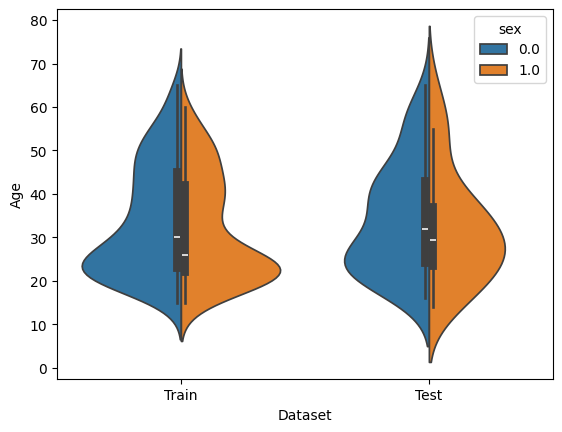

age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0

age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153

In [4]:
# Plot age distribution

sns.violinplot(x="set", y="age", hue="sex", data=participants, split=True)
plt.xticks(ticks=[0, 1], labels=["Train", "Test"])
plt.xlabel("Dataset")
plt.ylabel("Age")
plt.show()
display(participants[["age", "set"]].groupby("set").describe())
display(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())


In [5]:
participants.info()


<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 102
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  513 non-null    object 
 1   session         513 non-null    object 
 2   sex             513 non-null    float64
 3   age             513 non-null    float64
 4   diagnosis       513 non-null    object 
 5   study           513 non-null    object 
 6   site            513 non-null    object 
 7   TIV             513 non-null    float64
 8   CSF_Vol         513 non-null    float64
 9   GM_Vol          513 non-null    float64
 10  WM_Vol          513 non-null    float64
 11  set             513 non-null    object 
dtypes: float64(6), object(6)
memory usage: 52.1+ KB


In [6]:
object_columns = participants.select_dtypes(include="object").columns.tolist()
object_columns = [col for col in object_columns if col != "participant_id"]


In [7]:
participants.head()
for col in object_columns:
    print(f"Unique values for {col} : {participants[col].unique()}")


Unique values for session : ['V1']
Unique values for diagnosis : ['schizophrenia' 'control']
Unique values for study : ['SCHIZCONNECT-VIP']
Unique values for site : ['NU' 'MRN' 'WUSTL']
Unique values for set : ['train' 'test']


In [8]:
participants.describe()


,sex,age,TIV,CSF_Vol,GM_Vol,WM_Vol
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,0.372320,33.148148,1426.607843,284.849383,625.735858,514.981154
std,0.483895,12.600746,149.019602,68.807070,74.945900,63.742644
min,0.000000,14.000000,1071.499793,144.985388,428.563675,359.708027
25%,0.000000,23.000000,1327.256106,232.636949,570.983541,472.661075
50%,0.000000,29.000000,1420.479557,275.634286,620.268996,509.191309
75%,1.000000,43.000000,1531.174963,325.010302,677.852937,559.486417
max,1.000000,66.000000,1852.574833,570.503425,889.396408,741.492388


## Unsupervized analysis: Explore main sources of variabilities

Load ROIs data, `train_rois.csv` provides:

- Global volumes of "tissues": CerrebroSpinal Fluid (`CSF_Vol`), Grey (`GM_Vol`) and White Matter (`WM_Vol`) volume of participants.
- ROIs are starting at column `l3thVen_GM_Vol`. Note that `rois_train.loc[:, 'l3thVen_GM_Vol':]` matches `problem.get_train_data()[:, :284]`.


### b. ROIS


In [9]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv")).loc[
    :, "l3thVen_GM_Vol":
]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv")).loc[:, "l3thVen_GM_Vol":]
rois = pd.concat([rois_train, rois_test])


In [10]:
len(rois_train.columns)


284

### PCA on ROIs: explore global effect of age


,sum_sq,df,F,PR(>F)
diagnosis,2606.207928,1.0,29.245287,9.808873e-08
Residual,45538.013350,511.0,NaN,NaN


,sum_sq,df,F,PR(>F)
diagnosis,791.094363,1.0,10.876419,0.001042
Residual,37167.493121,511.0,NaN,NaN


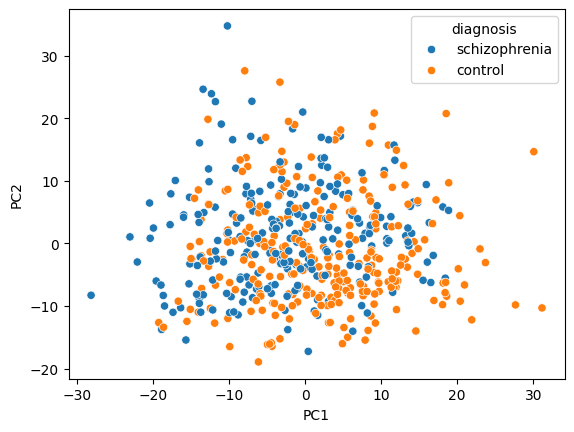

In [11]:
# PCA: Principal Component Analysis
PCs = PCA(n_components=2).fit_transform(rois)  # Fitting on ROIs
participants["PC1"], participants["PC2"] = (
    PCs[:, 0],
    PCs[:, 1],
)  # Adding the PCs to the participants df

sns.scatterplot(x="PC1", y="PC2", hue="diagnosis", data=participants)


# smf.ols
oneway = smf.ols("PC1 ~ diagnosis", participants).fit()  # Define the fitted model
display(
    sm.stats.anova_lm(oneway, typ=2)
)  # ANOVA test on a lineal model - type 2:tests whether the mean of a dependent variable is different
# across  different levels of a categorical variable.
# smf.ols -> Describe the relationship between the PC1 and PC2, and the diagnosis, i.e. predicting PC1/PC2 as a function of diagnosis
oneway = smf.ols("PC2 ~ diagnosis", participants).fit()
display(sm.stats.anova_lm(oneway, typ=2))

# SMF: StatsModels Formula API
# OLS: Ordinary Least Squares
# ANOVA: analysis of Variance test on the fitted model


The columns displayed in the output of the ANOVA test are:

1. `sum_sq`: This is the sum of squares. It represents the total variation in the dependent variable.

2. `df`: This stands for degrees of freedom. It's the number of values in the final calculation of a statistic that are free to vary.

3. `F`: This is the F statistic, a value you get when you run an ANOVA test or a regression analysis to find out if the means between two populations are significantly different.

4. `PR(>F)`: This is the p-value associated with the above F statistic. It tells you the probability of your null hypothesis being true. If this value is less than your significance level (commonly 0.05), you would reject the null hypothesis and conclude that the means are significantly different.


Diagnosis is associated with two first components, we expect to be abble to predict the diagnosis


## Machine learning

Import and read data


Load concatenated data: 284 features from ROIs and 331,695 features from VBM.


In [12]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695


## Feature extractor of ROIs or voxels within the brain (VBM)

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor`


In [13]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)


(410, 284)
(410, 331695)


## Models: Baseline and GridSearch

**Design of predictors and their evaluation using CV and test set**

The framework is evaluated with a cross-validation approach. The metrics used are the ROC-AUC (auc) and the balanced Accuracy (bacc).

First we propose a simple classification predictor based on ROIs features only:


In [19]:
from sklearn.preprocessing import LabelEncoder

participants_train["site"].nunique()
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit and transform the 'site' column in participants_train
participants_train["site_encoded"] = encoder.fit_transform(participants_train["site"])


In [48]:
groups = np.array(participants_train["site_encoded"].astype("int"))


In [17]:
#  Before Laura's group method

# # Function to perform model evaluation for a single model
# def evaluate_model(
#     model,
#     cv,
#     f_extractor,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     groups=None,
# ):
#     """
#     Evaluates a single model with a specific feature extractor and hyperparameters, providing scores before and after fitting.

#     Args:
#     - model: The model instance to be evaluated.
#     - param_grid (dict): A dictionary of hyperparameter grids for the model.
#     - cv: Cross-validation splitting strategy.
#     - f_extractor: The feature extractor instance.
#     - X_train (DataFrame): Training feature dataset.
#     - y_train (Series): Training target dataset.
#     - X_test (DataFrame): Test feature dataset.
#     - y_test (Series): Test target dataset.

#     Returns:
#     - result_df (DataFrame): DataFrame containing model evaluation results.
#     """
#     # Setting up the pipeline with the feature extractor and model
#     estimator = make_pipeline(f_extractor, model)

#     # Performing cross-validation to get initial scores
#     cv_results = cross_validate(
#         estimator,
#         X_train,
#         y_train,
#         scoring=["balanced_accuracy", "roc_auc"],
#         cv=cv,
#         return_train_score=True,
#         groups=groups,
#     )
#     print("# 5CV")
#     print(
#         "bACC=%.2f" % cv_results["test_balanced_accuracy"].mean(),
#         "ROC-AUC=%.2f" % cv_results["test_roc_auc"].mean(),
#     )

#     # Refit on all train
#     estimator.fit(X_train, y_train)
#     # Apply on test
#     y_pred_train = estimator.predict(X_train)
#     y_pred_test = estimator.predict(X_test)
#     score_pred_test = estimator.predict_proba(X_test)[:, 1]

#     bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
#     auc_test = metrics.roc_auc_score(y_test, score_pred_test)
#     print("# Test")
#     print("bACC=%.2f" % bacc_test, "ROC-AUC=%.2f" % auc_test)

#     # Creating a DataFrame from the results
#     result_df = pd.DataFrame(
#         {
#             "CV Balanced Accuracy": cv_results["test_balanced_accuracy"].mean(),
#             "CV ROC-AUC": cv_results["test_roc_auc"].mean(),
#             "Test Balanced Accuracy": bacc_test,
#             "Test ROC-AUC": auc_test,
#         },
#         index=[0],
#     )

#     return result_df


In [14]:
# from sklearn.model_selection import GridSearchCV


# def evaluate_model(
#     model,
#     cv,
#     f_extractor,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     groups=None,
# ):
#     # Setting up the pipeline with the feature extractor and model
#     estimator = make_pipeline(f_extractor, model)

#     # Performing cross-validation to get initial scores
#     if "group" is not None:
#         cv=problem.get_cv(X_train, y_train, groups=groups)
#         cv_results = cross_validate(
#             estimator,
#             X_train,
#             y_train,
#             scoring=["balanced_accuracy", "roc_auc"],
#             cv=cv,
#             return_train_score=True,
#             groups=groups,
#         )
#     else:
#         cv=problem.get_cv(X_train, y_train)
#         cv_results = cross_validate(
#             estimator,
#             X_train,
#             y_train,
#             scoring=["balanced_accuracy", "roc_auc"],
#             cv=cv,
#             return_train_score=True,
#         )

#     print("# CV")
#     print(
#         "bACC=%.2f" % cv_results["test_balanced_accuracy"].mean(),
#         "ROC-AUC=%.2f" % cv_results["test_roc_auc"].mean(),
#     )

#     # Refit on all train using GridSearchCV
#     param_grid = {"logisticregression__C": [0.1, 1, 10]}  # Example parameter grid
#     grid_search = GridSearchCV(
#         estimator,
#         param_grid,
#         cv=cv,
#         scoring="balanced_accuracy",
#         verbose=3,
#         return_train_score=True,
#         n_jobs=5,
#     )

#     if "group" in cv.__class__.__name__.lower():
#         grid_search.fit(X_train, y_train, groups=groups)
#     else:
#         grid_search.fit(X_train, y_train)

#     # Apply on test
#     y_pred_train = grid_search.predict(X_train)
#     y_pred_test = grid_search.predict(X_test)
#     score_pred_test = grid_search.predict_proba(X_test)[:, 1]

#     bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
#     auc_test = metrics.roc_auc_score(y_test, score_pred_test)
#     print("# Test")
#     print("bACC=%.2f" % bacc_test, "ROC-AUC=%.2f" % auc_test)

#     # Creating a DataFrame from the results
#     result_df = pd.DataFrame(
#         {
#             "CV Balanced Accuracy": cv_results["test_balanced_accuracy"].mean(),
#             "CV ROC-AUC": cv_results["test_roc_auc"].mean(),
#             "Test Balanced Accuracy": bacc_test,
#             "Test ROC-AUC": auc_test,
#         },
#         index=[0],
#     )

#     return result_df


In [49]:
#  Before Laura's group method


# Function to perform model evaluation for a single model
def evaluate_model(
    model,
    f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=False,
):
    """
    Evaluates a single model with a specific feature extractor and hyperparameters, providing scores before and after fitting.

    Args:
    - model: The model instance to be evaluated.
    - param_grid (dict): A dictionary of hyperparameter grids for the model.
    - cv: Cross-validation splitting strategy.
    - f_extractor: The feature extractor instance.
    - X_train (DataFrame): Training feature dataset.
    - y_train (Series): Training target dataset.
    - X_test (DataFrame): Test feature dataset.
    - y_test (Series): Test target dataset.

    Returns:
    - result_df (DataFrame): DataFrame containing model evaluation results.
    """
    # Setting up the pipeline with the feature extractor and model
    estimator = make_pipeline(f_extractor, model)

    # stratified_cv = (
    #     StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #     if groups == None
    #     else StratifiedGroupKFold(n_splits=3).split(
    #         X_train, y_train, groups=np.array(participants_train["site"].astype("int"))
    #     )
    # )
    # cv = stratified_cv

    # Performing cross-validation to get initial scores
    if groups is not None:
        cv = StratifiedGroupKFold(n_splits=3, shuffle=True).split(
            X_train,
            y_train,
            groups=np.array(participants_train["site_encoded"].astype("int")),
        )

        cv_results = cross_validate(
            estimator,
            X_train,
            y_train,
            scoring=["balanced_accuracy", "roc_auc"],
            cv=cv,
            return_train_score=True,
            groups=groups,
        )
    else:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(
            estimator,
            X_train,
            y_train,
            scoring=["balanced_accuracy", "roc_auc"],
            cv=cv,
            return_train_score=True,
        )
    print("# 5CV")
    print(
        "bACC=%.2f" % cv_results["test_balanced_accuracy"].mean(),
        "ROC-AUC=%.2f" % cv_results["test_roc_auc"].mean(),
    )

    # Refit on all train
    estimator.fit(X_train, y_train)
    # Apply on test
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    score_pred_test = estimator.predict_proba(X_test)[:, 1]

    bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
    auc_test = metrics.roc_auc_score(y_test, score_pred_test)
    print("# Test")
    print("bACC=%.2f" % bacc_test, "ROC-AUC=%.2f" % auc_test)

    # Creating a DataFrame from the results
    result_df = pd.DataFrame(
        {
            "CV Balanced Accuracy": cv_results["test_balanced_accuracy"].mean(),
            "CV ROC-AUC": cv_results["test_roc_auc"].mean(),
            "Test Balanced Accuracy": bacc_test,
            "Test ROC-AUC": auc_test,
        },
        index=[0],
    )

    return result_df


###  1. Linear Methods


### a. Logistic Regression


In [33]:
# ---------- Logistic Regression / Definition
model_linear = LogisticRegression(
    solver="saga",
    max_iter=10000,
)


param_grid_linear = {
    "logisticregression__C": [0.1, 1, 10],
    "logisticregression__penalty": ["l1", "l2"],
}


In [27]:
# ---------- Logistic Regression / ROI / StratKFold
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linear_roi = evaluate_model(
    model_linear,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.68 ROC-AUC=0.73
# Test
bACC=0.72 ROC-AUC=0.82
Elapsed time: 16.385972023010254


In [52]:
result_df_linear_roi


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.68312,0.731026,0.720265,0.823864


In [50]:
# ---------- Logistic Regression / ROI / StratGroupKFold

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linear_roi_group_site = evaluate_model(
    model=model_linear,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.67 ROC-AUC=0.73
# Test
bACC=0.72 ROC-AUC=0.82
Elapsed time: 12.561697006225586


In [51]:
result_df_linear_roi_group_site


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.665399,0.727114,0.720265,0.823864


In [53]:
# ---------- Logistic Regression / VBM / StratKFold

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_linear_vbm = evaluate_model(
    model_linear,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.71 ROC-AUC=0.80
# Test
bACC=0.70 ROC-AUC=0.79
Elapsed time for Voting Classifier: 5382.334787130356


In [54]:
result_df_linear_vbm


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.714348,0.797125,0.698106,0.790152


In [31]:
# ---------- Logistic Regression / VBM / StratGroupKFold

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_linear_vbm_group = evaluate_model(
    model_linear,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.68 ROC-AUC=0.77
# Test
bACC=0.70 ROC-AUC=0.79
Elapsed time: 3021.6112191677094


In [32]:
result_df_linear_vbm_group


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.679833,0.769927,0.698106,0.79053


#### b. LinearSVC


In [34]:
# TODO: Import necessary libraries
from sklearn.svm import LinearSVC


In [25]:
# ---------- Linear SVC / Definition
model_linearsvc = SVC(kernel="linear", probability=True)  # Necessary for 'l1' penalty


param_grid_linear_svc = {
    "linearsvc__C": [0.1, 1, 10],
    "linearsvc__penalty": ["l1", "l2"],
}


In [40]:
# ---------- Linear SVC / ROI / StratKFold
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linearsvc_roi = evaluate_model(
    model_linearsvc,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.63 ROC-AUC=0.69
# Test
bACC=0.71 ROC-AUC=0.80
Elapsed time: 6.450428009033203


In [41]:
result_df_linearsvc_roi


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.632036,0.685022,0.713826,0.801894


In [52]:
# ---------- Linear SVC / ROI / StratGroupKFold

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linearsvc_roi_group_site = evaluate_model(
    model_linearsvc,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.60 ROC-AUC=0.68
# Test
bACC=0.71 ROC-AUC=0.80
Elapsed time: 3.7978150844573975


In [53]:
result_df_linearsvc_roi_group_site


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.597681,0.675721,0.713826,0.801894


No VBM with SVC Linear beacause of hugigh dimens


### 2. Tree-based


####  a. RandomForest


In [ ]:
# ---------- RandomForest / Definitions

# RandomForest model
model_rf = RandomForestClassifier()

param_grid_rf = {
    "randomforestclassifier__n_estimators": [100, 200, 300],
    "randomforestclassifier__max_depth": [None, 5, 10],
}


In [ ]:
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_rf_roi = evaluate_model(
    model_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time for Voting Classifier: {end_time-start_time}")


# 5CV
bACC=0.73 ROC-AUC=0.78
# Test
bACC=0.73 ROC-AUC=0.80
Elapsed time for Voting Classifier: 8.55095911026001


In [ ]:
result_df_rf_roi


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.73178,0.776358,0.72822,0.795455


In [211]:
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_rf_roi_groups = evaluate_model(
    model_rf,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time for Voting Classifier: {end_time-start_time}")


# 5CV
bACC=0.67 ROC-AUC=0.76
# Test
bACC=0.73 ROC-AUC=0.79
Elapsed time for Voting Classifier: 1.9364290237426758


In [212]:
result_df_rf_roi_groups


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.67335,0.760291,0.726894,0.787689


In [ ]:
f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_rf_vbm = evaluate_model(
    model_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.68 ROC-AUC=0.76
# Test
bACC=0.63 ROC-AUC=0.74
Elapsed time for Voting Classifier: 37.388500928878784


In [ ]:
result_df_rf_vbm


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.678393,0.75505,0.631818,0.735985


####  b. XGBoost


In [ ]:
pip install xgboost


python(69755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from xgboost import XGBClassifier

model_xgboost = XGBClassifier()


In [ ]:
#  XGB / ROI / Strat
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_xgb_roi = evaluate_model(
    model_xgboost,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time for Voting Classifier: {end_time-start_time}")


# 5CV
bACC=0.74 ROC-AUC=0.82
# Test
bACC=0.75 ROC-AUC=0.84
Elapsed time for Voting Classifier: 4.742335081100464


In [ ]:
result_df_xgb_roi


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.737285,0.821701,0.754167,0.8375


In [ ]:
#  XGB / ROI / Group
f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_xgb_roi_groups = evaluate_model(
    model_xgboost,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time for Voting Classifier: {end_time-start_time}")


# 5CV
bACC=0.69 ROC-AUC=0.80
# Test
bACC=0.75 ROC-AUC=0.84
Elapsed time for Voting Classifier: 1.7494409084320068


In [ ]:
result_df_xgb_roi_groups


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.686208,0.797421,0.754167,0.8375


In [ ]:
#  XGBoost / ROI /Strat --- with RBF kernel
from sklearn.metrics.pairwise import rbf_kernel
import time

# Initialize your ROIsFeatureExtractor
f_extractor = ROIsFeatureExtractor()

# Kernelize the data
gamma = 0.1  # TODO: Adjust gamma as needed
X_train_kernel = rbf_kernel(X_train, gamma=gamma)
X_test_kernel = rbf_kernel(
    X_test, X_train, gamma=gamma
)  # Use X_train to anchor the test transformation

start_time = time.time()

# Evaluate the model with the kernelized data
result_df_xgb_roi = evaluate_model(
    model_xgboost,
    cv=strat_cv,
    f_extractor=f_extractor,  # Assuming f_extractor can handle the kernelized data
    X_train=X_train_kernel,
    y_train=y_train_encoded,
    X_test=X_test_kernel,
    y_test=y_test_encoded,
    groups=None,
)

end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.50 ROC-AUC=0.50
# Test
bACC=0.50 ROC-AUC=0.50
Elapsed time: 0.4053928852081299


In [ ]:
#  XGBoost / VBM /Strat --- with RBF kernel
from sklearn.metrics.pairwise import rbf_kernel
import time

# Initialize your ROIsFeatureExtractor
f_extractor = VBMFeatureExtractor()

# Kernelize the data
gamma = 0.0001  # TODO: Adjust gamma as needed
X_train_kernel = rbf_kernel(X_train, gamma=gamma)
X_test_kernel = rbf_kernel(
    X_test, X_train, gamma=gamma
)  # Use X_train to anchor the test transformation

start_time = time.time()

# Evaluate the model with the kernelized data
result_df_xgb_vbm = evaluate_model(
    model_xgboost,
    cv=strat_cv,
    f_extractor=f_extractor,  # Assuming f_extractor can handle the kernelized data
    X_train=X_train_kernel,
    y_train=y_train_encoded,
    X_test=X_test_kernel,
    y_test=y_test_encoded,
    groups=None,
)

end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.64 ROC-AUC=0.68
# Test
bACC=0.60 ROC-AUC=0.64
Elapsed time: 1.1007680892944336


In [ ]:
#  XGB / VBM / Strat

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_xgb_vbm = evaluate_model(
    model_xgboost,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.72 ROC-AUC=0.81
# Test
bACC=0.70 ROC-AUC=0.80
Elapsed time for Voting Classifier: 1615.7503590583801


In [ ]:
result_df_xgb_vbm


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.718673,0.810236,0.700758,0.795833


XGBoost with rbf kernel


In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

# Example dataset
X = np.array([[1, 2], [3, 4]])  # TODO: Replace with your data

# Compute the RBF kernel matrix
gamma = 0.1  # TODO: Adjust gamma, which is 1/(2*sigma^2) for the RBF kernel
K = rbf_kernel(X, gamma=gamma)

print(K)


###  3. Non-Linear


#### a. SVM


In [204]:
model_svm = SVC(probability=True)
param_grid_svm = {
    "C": [0.1, 1, 10, 100],  # Example values
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "linear"],
}


In [ ]:
# Evaluating a model with ROIs feature extractor and SVM

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_svm_roi = evaluate_model(
    model_svm,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.63 ROC-AUC=0.70
# Test
bACC=0.64 ROC-AUC=0.68
Elapsed time: 4.510223865509033


In [ ]:
result_df_svm_roi.style.background_gradient(cmap="Reds")


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.632443,0.699470,0.643561,0.682197


In [216]:
# Evaluating a model with ROIs feature extractor and SVM

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_svm_roi_groups = evaluate_model(
    model_svm,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.59 ROC-AUC=0.66
# Test
bACC=0.64 ROC-AUC=0.68
Elapsed time: 1.637294054031372


In [217]:
result_df_svm_roi_groups


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.589176,0.659538,0.643561,0.682197


#### b. KNN


In [206]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],  # Example values for number of neighbors
    "weights": ["uniform", "distance"],  # Weight options
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],  # Algorithm options
}


In [ ]:
# Evaluating a model with ROIs feature extractor and KNN

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_knn_roi = evaluate_model(
    model_knn,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.57 ROC-AUC=0.62
# Test
bACC=0.63 ROC-AUC=0.68
Elapsed time: 6.640761852264404


In [ ]:
result_df_knn_roi.style.background_gradient(cmap="Reds")


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.572211,0.616537,0.626705,0.681439


In [214]:
# Evaluating a model with ROIs feature extractor and KNN

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_knn_roi_groups = evaluate_model(
    model_knn,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.54 ROC-AUC=0.55
# Test
bACC=0.63 ROC-AUC=0.68
Elapsed time: 1.520111083984375


In [215]:
result_df_knn_roi_groups


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.544655,0.551178,0.626705,0.681439


In [ ]:
# Evaluating a model with VBM feature extractor and KNN

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_knn_vbm = evaluate_model(
    model_knn,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=None,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.58 ROC-AUC=0.61
# Test
bACC=0.63 ROC-AUC=0.62
Elapsed time: 50.7613308429718


In [ ]:
result_df_knn_vbm.style.background_gradient(cmap="Reds")


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.584475,0.613483,0.629167,0.622159


In [209]:
# KNN / VBM / Group

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_knn_vbm_groups = evaluate_model(
    model_knn,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


# 5CV
bACC=0.63 ROC-AUC=0.64
# Test
bACC=0.63 ROC-AUC=0.62
Elapsed time: 15.187710762023926


In [210]:
result_df_knn_vbm_groups


,CV Balanced Accuracy,CV ROC-AUC,Test Balanced Accuracy,Test ROC-AUC
0,0.626206,0.641968,0.629167,0.622159


### c/Evaluation


## Update on the baseline


### Kernels


In [20]:
binary_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["#332288", "white", "#AA4499"]
)
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#332288",
        "#88CCEE",
        "#44AA99",
        "#117733",
        "#999933",
        "#DDCC77",
        "#CC6677",
        "#882255",
        "#AA4499",
    ]
)


In [21]:
estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler())


In [36]:
# TODO: Import necessary libraries and classes if not already done

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler())

# Encode the labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the feature extractor to the training data and transform the training data
X_train_roi = estimator.fit_transform(X_train, y_train_encoded)
X_test_roi = estimator.transform(X_test)


In [ ]:
# kernel names
kernels = ["linear", "poly", "rbf", "sigmoid"]


In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Kernel names
kernels = ["linear", "poly", "rbf", "sigmoid"]

# Dictionary to store results
results = {}

# Evaluating an SVC model with VBM feature extractor for each kernel
for kernel in kernels:
    print(f"Kernel: {kernel} ")

    # Initialize the SVM model with the current kernel and probability=True
    model_svc = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))

    # Initialize the feature extractor
    f_extractor = ROIsFeatureExtractor()

    # Start timing
    start_time = time.time()

    # Evaluate the model and store the result in the dictionary
    results[f"result_df_svc_roi_{kernel}"] = evaluate_model(
        model_svc,  # This is now an SVC model with the specified kernel and probability enabled
        cv=strat_cv,
        f_extractor=f_extractor,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        groups=None,
    )

    # End timing
    end_time = time.time()

    # Print elapsed time
    print(f"Elapsed time for {kernel} kernel: {end_time - start_time} seconds")
    print("-------------------")


Kernel: linear 
# 5CV
bACC=0.66 ROC-AUC=0.72
# Test
bACC=0.68 ROC-AUC=0.75
Elapsed time for linear kernel: 7.478082656860352 seconds
-------------------
Kernel: poly 
# 5CV
bACC=0.62 ROC-AUC=0.78
# Test
bACC=0.58 ROC-AUC=0.78
Elapsed time for poly kernel: 7.166824817657471 seconds
-------------------
Kernel: rbf 
# 5CV
bACC=0.73 ROC-AUC=0.82
# Test
bACC=0.75 ROC-AUC=0.84
Elapsed time for rbf kernel: 7.311755895614624 seconds
-------------------
Kernel: sigmoid 
# 5CV
bACC=0.68 ROC-AUC=0.72
# Test
bACC=0.73 ROC-AUC=0.78
Elapsed time for sigmoid kernel: 7.072613954544067 seconds
-------------------


### GridSearch


In [23]:
#  all metrics
def evaluate_model_gridsearch(
    model,
    param_grid,
    cv,
    f_extractor,
    X_train,
    y_train,
    X_test,
    y_test,
    groups=None,
):
    # Setting up the pipeline with the feature extractor and model
    estimator = make_pipeline(f_extractor, StandardScaler(), model)

    # Performing initial cross-validation to get baseline scores and fitting time
    cv_results = cross_validate(
        estimator,
        X_train,
        y_train,
        scoring=["balanced_accuracy", "roc_auc", "precision", "recall", "f1"],
        cv=cv,
        return_train_score=True,
        return_estimator=True,
        groups=groups,
    )

    # Calculate baseline metrics and average fitting time
    baseline_metrics = {
        "Balanced Accuracy": cv_results["test_balanced_accuracy"].mean(),
        "ROC-AUC": cv_results["test_roc_auc"].mean(),
        "Precision": cv_results["test_precision"].mean(),
        "Recall": cv_results["test_recall"].mean(),
        "F1 Score": cv_results["test_f1"].mean(),
    }
    baseline_fit_time = cv_results["fit_time"].mean()

    # Setting up GridSearchCV to find the best parameters for the model
    grid_search = GridSearchCV(
        estimator,
        param_grid,
        scoring="balanced_accuracy",
        refit="balanced_accuracy",
        cv=cv,
        verbose=1,
        n_jobs=-1,
    )

    # Fitting GridSearchCV to find the best parameters and model, and measure fitting time
    grid_search.fit(X_train, y_train, groups=groups)
    best_model = grid_search.best_estimator_
    grid_search_fit_time = grid_search.cv_results_["mean_fit_time"].mean()

    # Evaluating the best model on the test set
    y_pred_test = best_model.predict(X_test)
    score_pred_test = best_model.predict_proba(X_test)[:, 1]

    # Calculating test metrics for the best model
    test_metrics = {
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test),
        "ROC-AUC": roc_auc_score(y_test, score_pred_test),
        "Precision": precision_score(y_test, y_pred_test),
        "Recall": recall_score(y_test, y_pred_test),
        "F1 Score": f1_score(y_test, y_pred_test),
    }

    # Creating a DataFrame from the results including the differences and fitting times
    result_df = pd.DataFrame(
        {
            "Metric": [
                "Balanced Accuracy",
                "ROC-AUC",
                "Precision",
                "Recall",
                "F1 Score",
                "Fit Time (s)",
            ],
            "Baseline": list(baseline_metrics.values()) + [baseline_fit_time],
            "GridSearch": list(test_metrics.values()) + [grid_search_fit_time],
            "Difference": [
                test_metrics[metric] - baseline_metrics[metric]
                for metric in baseline_metrics.keys()
            ]
            + [grid_search_fit_time - baseline_fit_time],
        }
    )

    return result_df


LogisticRegression


In [ ]:
# StratCV

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linear_roi_gs = evaluate_model_gridsearch(
    model=model_linear,
    param_grid=param_grid_linear,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Elapsed time: 48.78076219558716


In [ ]:
result_df_linear_roi_gs.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.68312,0.731026,0.651524,0.654623,0.650435,3.15951
GridSearch,0.738447,0.826894,0.805556,0.604167,0.690476,11.263332
Difference,0.055327,0.095868,0.154032,-0.050456,0.040041,8.103822


In [ ]:
# StratGroupCV

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_linear_roi_gs_groups_site = evaluate_model_gridsearch(
    model=model_linear,
    param_grid=param_grid_linear,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Elapsed time: 18.6110258102417


In [ ]:
result_df_linear_roi_gs_groups_site.T.style.background_gradient(cmap="Reds")


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.654364,0.719115,0.633954,0.622581,0.628100,3.373434
GridSearch,0.738447,0.826894,0.805556,0.604167,0.690476,9.372917
Difference,0.084083,0.107779,0.171602,-0.018414,0.062377,5.999483


In [ ]:
megatable = pd.concat(
    [result_df_linear_roi_gs, result_df_linear_roi_gs_groups_site], axis=1
)
megatable


RandomForest


In [ ]:
# StratCV

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_rf_roi_gs = evaluate_model_gridsearch(
    model=model_rf,
    param_grid=param_grid_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 33.781896114349365


In [ ]:
result_df_rf_roi_gs.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.704821,0.765405,0.711845,0.621764,0.661089,1.191369
GridSearch,0.738636,0.804924,0.705882,0.75,0.727273,6.759435
Difference,0.033815,0.03952,-0.005962,0.128236,0.066183,5.568065


In [ ]:
# StratGroupCV

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_rf_roi_gs_groups = evaluate_model_gridsearch(
    model=model_rf,
    param_grid=param_grid_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 25.405595064163208


In [ ]:
result_df_rf_roi_gs_groups.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.708242,0.787388,0.709646,0.637696,0.667219,1.332972
GridSearch,0.746402,0.796212,0.729167,0.729167,0.729167,4.398507
Difference,0.03816,0.008824,0.01952,0.091471,0.061948,3.065535


In [ ]:
megatable = pd.concat([result_df_rf_roi_gs, result_df_rf_roi_gs_groups], axis=1)
megatable


,Metric,Baseline,GridSearch,Difference,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.704821,0.738636,0.033815,Balanced Accuracy,0.708242,0.746402,0.038160
1,ROC-AUC,0.765405,0.804924,0.039520,ROC-AUC,0.787388,0.796212,0.008824
2,Precision,0.711845,0.705882,-0.005962,Precision,0.709646,0.729167,0.019520
3,Recall,0.621764,0.750000,0.128236,Recall,0.637696,0.729167,0.091471
4,F1 Score,0.661089,0.727273,0.066183,F1 Score,0.667219,0.729167,0.061948
5,Fit Time (s),1.191369,6.759435,5.568065,Fit Time (s),1.332972,4.398507,3.065535


In [ ]:
# StratCV

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_rf_vbm_gs = evaluate_model_gridsearch(
    model=model_rf,
    param_grid=param_grid_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 435.2170581817627


In [ ]:
result_df_rf_vbm_gs.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.660355,0.742128,0.677523,0.541821,0.598768,5.514359
GridSearch,0.642235,0.718939,0.657895,0.520833,0.581395,98.774709
Difference,-0.01812,-0.023188,-0.019628,-0.020987,-0.017373,93.260351


In [ ]:
# StratGroupCV

f_extractor = VBMFeatureExtractor()

start_time = time.time()
result_df_rf_vbm_gs_groups = evaluate_model_gridsearch(
    model=model_rf,
    param_grid=param_grid_rf,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 304.6167061328888


In [ ]:
result_df_rf_vbm_gs_groups


,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.688398,0.603220,-0.085178
1,ROC-AUC,0.763880,0.681629,-0.082251
2,Precision,0.703985,0.605263,-0.098722
3,Recall,0.584068,0.479167,-0.104902
4,F1 Score,0.635965,0.534884,-0.101081
5,Fit Time (s),5.080534,63.750996,58.670463


In [ ]:
megatable = pd.concat([result_df_rf_vbm_gs, result_df_rf_vbm_gs_groups], axis=1)
megatable


,Metric,Baseline,GridSearch,Difference,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.660355,0.642235,-0.018120,Balanced Accuracy,0.688398,0.603220,-0.085178
1,ROC-AUC,0.742128,0.718939,-0.023188,ROC-AUC,0.763880,0.681629,-0.082251
2,Precision,0.677523,0.657895,-0.019628,Precision,0.703985,0.605263,-0.098722
3,Recall,0.541821,0.520833,-0.020987,Recall,0.584068,0.479167,-0.104902
4,F1 Score,0.598768,0.581395,-0.017373,F1 Score,0.635965,0.534884,-0.101081
5,Fit Time (s),5.514359,98.774709,93.260351,Fit Time (s),5.080534,63.750996,58.670463


XGBBoost


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [29]:
from xgboost import XGBClassifier

model_xgboost = XGBClassifier()


param_grid_xgboost = {
    "xgbclassifier__n_estimators": [100, 200, 300],  # Parameters for XGBClassifier
    "xgbclassifier__learning_rate": [0.1, 0.01, 0.001],
    "xgbclassifier__max_depth": [3, 5, 7],
}


In [33]:
# StratCV

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_xgb_roi_gs = evaluate_model_gridsearch(
    model=model_xgboost,
    param_grid=param_grid_xgboost,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Elapsed time: 119.98071599006653


In [34]:
result_df_xgb_roi_gs.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.737285,0.821701,0.750177,0.659317,0.700745,1.781913
GridSearch,0.763258,0.836364,0.772727,0.708333,0.73913,9.236366
Difference,0.025973,0.014662,0.022551,0.049016,0.038386,7.454453


In [35]:
# XGB / ROI ? Group

f_extractor = ROIsFeatureExtractor()

start_time = time.time()
result_df_xgb_roi_gs_groups = evaluate_model_gridsearch(
    model=model_xgboost,
    param_grid=param_grid_xgboost,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 2 folds for each of 27 candidates, totalling 54 fits
Elapsed time: 50.63329195976257


In [36]:
result_df_xgb_roi_gs_groups.T


,0,1,2,3,4,5
Metric,Balanced Accuracy,ROC-AUC,Precision,Recall,F1 Score,Fit Time (s)
Baseline,0.686208,0.797421,0.638813,0.781268,0.697845,2.677964
GridSearch,0.763258,0.830303,0.772727,0.708333,0.73913,8.63152
Difference,0.07705,0.032882,0.133914,-0.072934,0.041285,5.953556


In [37]:
megatable = pd.concat([result_df_xgb_roi_gs, result_df_xgb_roi_gs_groups], axis=1)
megatable


,Metric,Baseline,GridSearch,Difference,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.737285,0.763258,0.025973,Balanced Accuracy,0.686208,0.763258,0.077050
1,ROC-AUC,0.821701,0.836364,0.014662,ROC-AUC,0.797421,0.830303,0.032882
2,Precision,0.750177,0.772727,0.022551,Precision,0.638813,0.772727,0.133914
3,Recall,0.659317,0.708333,0.049016,Recall,0.781268,0.708333,-0.072934
4,F1 Score,0.700745,0.739130,0.038386,F1 Score,0.697845,0.739130,0.041285
5,Fit Time (s),1.781913,9.236366,7.454453,Fit Time (s),2.677964,8.631520,5.953556


SVC, kernel=='linear'


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Define your SVC model
model_svc = SVC(kernel="linear", probability=True)

# Define the parameter grid for the SVC
param_grid_svc = {"svc__C": [0.1, 1, 10], "svc__gamma": [1, 0.1, 0.01]}

# Initialize your feature extractor
f_extractor = ROIsFeatureExtractor()


# Call the evaluate_model_gridsearch function with the SVC model and parameter grid
start_time = time.time()
result_df_svc_linear_gs_roi = evaluate_model_gridsearch(
    model=model_svc,
    param_grid=param_grid_svc,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 27.327641010284424


In [ ]:
result_df_svc_linear_gs_roi


,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.632036,0.717614,0.085578
1,ROC-AUC,0.685022,0.829356,0.144334
2,Precision,0.599543,0.794118,0.194574
3,Recall,0.601849,0.562500,-0.039349
4,F1 Score,0.598309,0.658537,0.060227
5,Fit Time (s),1.357315,4.880603,3.523289


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Define your SVC model
model_svc = SVC(kernel="linear", probability=True)

# Define the parameter grid for the SVC
param_grid_svc = {"svc__C": [0.1, 1, 10], "svc__gamma": [1, 0.1, 0.01]}

# Initialize your feature extractor
f_extractor = ROIsFeatureExtractor()


# Call the evaluate_model_gridsearch function with the SVC model and parameter grid
start_time = time.time()
result_df_svc_linear_gs_roi_group = evaluate_model_gridsearch(
    model=model_svc,
    param_grid=param_grid_svc,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Elapsed time: 13.725724935531616


In [ ]:
result_df_svc_linear_gs_roi_group


,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.632632,0.717614,0.084981
1,ROC-AUC,0.680841,0.829545,0.148704
2,Precision,0.592352,0.794118,0.201766
3,Recall,0.644199,0.562500,-0.081699
4,F1 Score,0.616943,0.658537,0.041594
5,Fit Time (s),2.386960,4.839717,2.452757


In [ ]:
megatable = pd.concat(
    [result_df_svc_linear_gs_roi, result_df_svc_linear_gs_roi_group], axis=1
)
megatable


,Metric,Baseline,GridSearch,Difference,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.632036,0.717614,0.085578,Balanced Accuracy,0.632632,0.717614,0.084981
1,ROC-AUC,0.685022,0.829356,0.144334,ROC-AUC,0.680841,0.829545,0.148704
2,Precision,0.599543,0.794118,0.194574,Precision,0.592352,0.794118,0.201766
3,Recall,0.601849,0.562500,-0.039349,Recall,0.644199,0.562500,-0.081699
4,F1 Score,0.598309,0.658537,0.060227,F1 Score,0.616943,0.658537,0.041594
5,Fit Time (s),1.357315,4.880603,3.523289,Fit Time (s),2.386960,4.839717,2.452757


SVC, kernel='rbf'


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Define your SVC model
model_svc = SVC(kernel="rbf", probability=True)

# Define the parameter grid for the SVC
param_grid_svc = {"svc__C": [0.1, 1, 10], "svc__gamma": [1, 0.1, 0.01]}

# Initialize your feature extractor
f_extractor = ROIsFeatureExtractor()


# Call the evaluate_model_gridsearch function with the SVC model and parameter grid
start_time = time.time()
result_df_svc_rbf_gs = evaluate_model_gridsearch(
    model=model_svc,
    param_grid=param_grid_svc,
    cv=strat_cv,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Elapsed time: 24.61484694480896


In [ ]:
result_df_svc_rbf_gs


,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.632443,0.700947,0.068504
1,ROC-AUC,0.699470,0.725758,0.026288
2,Precision,0.655911,0.660377,0.004466
3,Recall,0.499431,0.729167,0.229736
4,F1 Score,0.562842,0.693069,0.130228
5,Fit Time (s),0.653082,4.976191,4.323109


In [ ]:
# SVC RBF / ROI / Group

# Initialize your feature extractor
f_extractor = ROIsFeatureExtractor()

# Call the evaluate_model_gridsearch function with the SVC model and parameter grid
start_time = time.time()
result_df_svc_rbf_gs_group = evaluate_model_gridsearch(
    model=model_svc,
    param_grid=param_grid_svc,
    cv=strat_group_kfold,
    f_extractor=f_extractor,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    groups=groups_site,
)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time}")


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Elapsed time: 16.476353883743286


In [ ]:
result_df_svc_rbf_gs_group


,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.589176,0.651515,0.062339
1,ROC-AUC,0.659538,0.739394,0.079856
2,Precision,0.617262,0.615385,-0.001878
3,Recall,0.514827,0.666667,0.151839
4,F1 Score,0.542571,0.640000,0.097429
5,Fit Time (s),2.109760,7.005453,4.895693


In [ ]:
megatable = pd.concat([result_df_svc_rbf_gs, result_df_svc_rbf_gs_group], axis=1)
megatable


,Metric,Baseline,GridSearch,Difference,Metric,Baseline,GridSearch,Difference
0,Balanced Accuracy,0.632443,0.700947,0.068504,Balanced Accuracy,0.589176,0.651515,0.062339
1,ROC-AUC,0.699470,0.725758,0.026288,ROC-AUC,0.659538,0.739394,0.079856
2,Precision,0.655911,0.660377,0.004466,Precision,0.617262,0.615385,-0.001878
3,Recall,0.499431,0.729167,0.229736,Recall,0.514827,0.666667,0.151839
4,F1 Score,0.562842,0.693069,0.130228,F1 Score,0.542571,0.640000,0.097429
5,Fit Time (s),0.653082,4.976191,4.323109,Fit Time (s),2.109760,7.005453,4.895693


## Test submission locally

The submissions need to be located in the submissions folder. For instance for `starting_kit`, it should be located in `submissions/submissions/starting_kit`.

Copy everything required (the cell bellow) to build your estimator in a submission file: `submissions/submissions/starting_kit/estimator.py`. This file must contain a function `get_estimator()`:


In [ ]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(
        ROIsFeatureExtractor(),
        SVC(kernel="linear", probability=True),
    )

    return estimator


Run locally:

```
ramp-test --submission starting_kit
```

## Submission on RAMP:

Follow the instructions: [Submitting to a ramp event](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#submitting-to-a-ramp-event)

The event is [Predict schizophrenia from brain grey matter (classification)](https://ramp.studio/problems/brain_anatomy_schizophrenia)


ramp-test --submission starting_kit


In [ ]:
!ramp-test --submission starting_kit


Testing Predict schizophrenia from     brain grey matter (classification)
Reading train and test files from ./data/ ...
Reading cv ...
Traceback (most recent call last):
  File "/Users/kenzabenkirane/anaconda3/envs/brain-anatomy-schizophrenia/bin/ramp-test", line 8, in <module>
    sys.exit(start())
             ^^^^^^^
  File "/Users/kenzabenkirane/anaconda3/envs/brain-anatomy-schizophrenia/lib/python3.12/site-packages/rampwf/utils/cli/testing.py", line 117, in start
    main()
  File "/Users/kenzabenkirane/anaconda3/envs/brain-anatomy-schizophrenia/lib/python3.12/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kenzabenkirane/anaconda3/envs/brain-anatomy-schizophrenia/lib/python3.12/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/Users/kenzabenkirane/anaconda3/envs/brain-anatomy-schizophrenia/lib/python3.12/site-packages/click/co